In [1]:
%load_ext autotime
import pandas as pd  # Tabular data
from glob import glob  # File pattern matching
import os  # Operating System
import geopandas as gpd  # Geospatial data
import re  # Regular expressions
import math
from tqdm.auto import tqdm  # Progress bars
from tqdm.contrib.concurrent import thread_map, process_map  # Parallel operations
import rapidfuzz # Fuzzy string matching
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 130)

import platform
if platform.system() == "Windows":
  prefix = "Z:/"
else:
  prefix = "ressci201900060-RNC2-Coastal/"

df = pd.concat(pd.read_csv(f) for f in ["meta.csv"])
# Filter to just shapefiles that have the CPS column defined
df = df[df.CPS & (df.n_lines > 0)]
df["Pixel_ER"] = (
    df.res.str.replace("(", "", regex=False).str.split(",").str[0].astype(float)
)
#df = df[["filename", "matched_image", "Pixel_ER"]]
# Testing with BigBay
# df = df[df.filename.str.contains("BigBay")]
df

,filename,matched_image,match_score,Source,n_lines,CPS,Photoscale,Pixel_Er,driver,dtype,nodata,width,height,count,crs,transform,blockxsize,blockysize,tiled,interleave,GCPs,res,compress,photometric,Pixel_ER
0,Retrolens/Otago/AllansBeach/Shorelines/AllansBeach_18FEB1970_mosaic.shp,Retrolens/Otago/AllansBeach/Stack/AllansBeach_18FEB1970_mosaic.jp2,100.0,RLN,5,True,True,True,JP2OpenJPEG,uint16,256.0,5996,4025,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.71, 0.00, 1419154.97|\n| 0.00,-0.71, 4917998.07|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,pixel,0,"(0.7067293982912914, 0.7067293982913497)",NaN,NaN,0.706729
1,Retrolens/Otago/AllansBeach/Shorelines/AllansBeach_15OCT1942_mosaic.shp,Retrolens/Otago/AllansBeach/Stack/AllansBeach_15OCT1942_mosaic.jp2,100.0,RLN,6,True,True,True,JP2OpenJPEG,uint16,256.0,8899,5738,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.48, 0.00, 1419198.34|\n| 0.00,-0.48, 4917975.85|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,pixel,0,"(0.48367299928392365, 0.4836729992839708)",NaN,NaN,0.483673
2,Retrolens/Otago/CoalPoint_SmithsBeach/Shorelines/CoalPoint_SmithsBeach_20FEB1975.shp,Retrolens/Otago/CoalPoint_SmithsBeach/Stack/CoalPoint_SmithsBeach_20FEB1975_mosaic.jp2,100.0,RL,11,True,True,True,JP2OpenJPEG,uint16,256.0,9522,8052,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.71, 0.00, 1360345.93|\n| 0.00,-0.71, 4871576.51|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,pixel,0,"(0.7111884325875153, 0.7111884325875041)",NaN,NaN,0.711188
3,Retrolens/Otago/AllansBeach/Shorelines/AllansBeach_7MAR1975_mosaic.shp,Retrolens/Otago/AllansBeach/Stack/AllansBeach_7MAR1975_mosaic.jp2,100.0,RLN,5,True,True,True,JP2OpenJPEG,uint16,256.0,2882,1673,1,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 1.43, 0.00, 1419230.66|\n| 0.00,-1.43, 4917827.51|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,NaN,0,"(1.425043057151705, 1.425043057151544)",NaN,NaN,1.425043
4,Retrolens/Otago/AllansBeach/Shorelines/AllansBeach_17MAR2000_mosaic.shp,Retrolens/Otago/AllansBeach/Stack/AllansBeach_17MAR2000_mosaic.jp2,100.0,RLN,5,True,True,True,JP2OpenJPEG,uint16,256.0,3480,2009,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 1.42, 0.00, 1419105.53|\n| 0.00,-1.42, 4918049.11|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,pixel,0,"(1.4190181270697362, 1.419018127069604)",NaN,NaN,1.419018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2048,Retrolens/HawkesBay/Porangahau/Shorelines/Porangahau_27JAN1999.shp,Retrolens/HawkesBay/Porangahau/Stack/Porangahau_27JAN1999_mosaic.jp2,100.0,RL,2,True,True,True,JP2OpenJPEG,uint16,256.0,6562,3932,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 1.48, 0.00, 1912837.57|\n| 0.00,-1.48, 5541645.49|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,pixel,0,"(1.4769243640306127, 1.4769243640305962)",NaN,NaN,1.476924
2049,Retrolens/HawkesBay/Porangahau/Shorelines/Porangahau_14OCT1980.shp,Retrolens/HawkesBay/Porangahau/Stack/Porangahau_14OCT1980_mosaic.jp2,100.0,RL,2,True,True,True,JP2OpenJPEG,uint16,256.0,11854,5503,3,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.78, 0.00, 1913709.10|\n| 0.00,-0.78, 5541837.03|\n| 0.00, 0.00, 1.00|",1024.0,1024,True,pixel,0,"(0.7790386525610454, 0.7790386525610458)",NaN,NaN,0.779039
2050,Retrolens/HawkesBay/Porangahau/Shorelines/Porangahau_25MAR1965.shp,Retrolens/HawkesBay/Porangahau/Stack/Porangahau_25MAR1965

In [2]:
df = pd.concat((df, pd.read_csv(prefix+"Nick/LDS_matches.csv")))
df

,filename,matched_image,match_score,Source,n_lines,CPS,Photoscale,Pixel_Er,driver,dtype,nodata,width,height,count,crs,transform,blockxsize,blockysize,tiled,interleave,GCPs,res,compress,photometric,Pixel_ER,matched_index_tiles,date,DSASDate,matched_date,matched_date_col
0,Retrolens/Otago/AllansBeach/Shorelines/AllansBeach_18FEB1970_mosaic.shp,Retrolens/Otago/AllansBeach/Stack/AllansBeach_18FEB1970_mosaic.jp2,100.0,RLN,5.0,True,True,True,JP2OpenJPEG,uint16,256.0,5996.0,4025.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.71, 0.00, 1419154.97|\n| 0.00,-0.71, 4917998.07|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,pixel,0.0,"(0.7067293982912914, 0.7067293982913497)",NaN,NaN,0.706729,NaN,NaN,NaN,NaN,NaN
1,Retrolens/Otago/AllansBeach/Shorelines/AllansBeach_15OCT1942_mosaic.shp,Retrolens/Otago/AllansBeach/Stack/AllansBeach_15OCT1942_mosaic.jp2,100.0,RLN,6.0,True,True,True,JP2OpenJPEG,uint16,256.0,8899.0,5738.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.48, 0.00, 1419198.34|\n| 0.00,-0.48, 4917975.85|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,pixel,0.0,"(0.48367299928392365, 0.4836729992839708)",NaN,NaN,0.483673,NaN,NaN,NaN,NaN,NaN
2,Retrolens/Otago/CoalPoint_SmithsBeach/Shorelines/CoalPoint_SmithsBeach_20FEB1975.shp,Retrolens/Otago/CoalPoint_SmithsBeach/Stack/CoalPoint_SmithsBeach_20FEB1975_mosaic.jp2,100.0,RL,11.0,True,True,True,JP2OpenJPEG,uint16,256.0,9522.0,8052.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 0.71, 0.00, 1360345.93|\n| 0.00,-0.71, 4871576.51|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,pixel,0.0,"(0.7111884325875153, 0.7111884325875041)",NaN,NaN,0.711188,NaN,NaN,NaN,NaN,NaN
3,Retrolens/Otago/AllansBeach/Shorelines/AllansBeach_7MAR1975_mosaic.shp,Retrolens/Otago/AllansBeach/Stack/AllansBeach_7MAR1975_mosaic.jp2,100.0,RLN,5.0,True,True,True,JP2OpenJPEG,uint16,256.0,2882.0,1673.0,1.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 1.43, 0.00, 1419230.66|\n| 0.00,-1.43, 4917827.51|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,NaN,0.0,"(1.425043057151705, 1.425043057151544)",NaN,NaN,1.425043,NaN,NaN,NaN,NaN,NaN
4,Retrolens/Otago/AllansBeach/Shorelines/AllansBeach_17MAR2000_mosaic.shp,Retrolens/Otago/AllansBeach/Stack/AllansBeach_17MAR2000_mosaic.jp2,100.0,RLN,5.0,True,True,True,JP2OpenJPEG,uint16,256.0,3480.0,2009.0,3.0,"PROJCS[""NZGD2000 / New Zealand Transverse Mercator 2000"",GEOGCS[""NZGD2000"",DATUM[""New_Zealand_Geodetic_Datum_2000"",SPHEROID[""G...","| 1.42, 0.00, 1419105.53|\n| 0.00,-1.42, 4918049.11|\n| 0.00, 0.00, 1.00|",1024.0,1024.0,True,pixel,0.0,"(1.4190181270697362, 1.419018127069604)",NaN,NaN,1.419018,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,Retrolens/Northland/BayleysBeach/Shorelines/BayleysBeach_06NOV2015.shp,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400000,['SpatialData/Mosaics/Footprint shapefiles/Northland Footrpints/northland-04m-rural-aerial-photos-index-tiles-2014-2016.shp'],'2015-11-06,'06/11/2015,"'06/11/2015, 07/11/2015",DATE_DMY
377,Retrolens/Taranaki/Oeo/Shorelines/Oeo_31OCT2016.shp,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.300000,['SpatialData/Mosaics/Footprint shapefiles/Taranaki Footprints/taranaki-03m-rural-aerial-photos-index-tiles-2016-2018.shp'],'2016-10-31,'31/10/2016,'31/10/2016,FLOWN
378,Retrolens/Waikato/Taharoa/Shorelines/Taharoa_10MAR2018.shp,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.300000,['SpatialData/Mosaics/Footprint shapefil

Total UNCY:  
Total shoreline uncertainty (Et) is calculated as the root sum of squares of the pixel error (Ep), georeferencing error (Eg) and digitising error (Ed)  

$E_t = \sqrt{E_p^2 + E_g^2 + E_d^2}$

In [3]:
#for f in df.filename:
#    print(f)
#    print(gpd.read_file(prefix+f))

In [4]:
#df = df[df.filename.str.startswith("Retrolens/Northland")]
#len(df)

In [5]:
# Warning: do not interrupt this cell while it is running. Doing so can delete or empty shapefiles that are in the process of being written.

def get_scale(filename, DSASDate, year):
    # Find CSV for AOI
    bits = filename.split("/")
    terminator = min(
        bits.index("Stack") if "Stack" in bits else 1024,
        bits.index("Shorelines") if "Shorelines" in bits else 1024,
    )
    bits = bits[:terminator]
    csv_path_pattern = f"{prefix}{'/'.join(bits)}/*.csv"
    csv_candidates = glob(csv_path_pattern)
    if len(csv_candidates) == 0:
        raise ValueError(f"No CSV found for {csv_path_pattern}")
    elif len(csv_candidates) > 1:
        print(f"Ambiguous CSVs: {csv_candidates}")
        csv_candidates = [csv_candidates[0]]
    assert len(csv_candidates) == 1
    csv_filename = csv_candidates[0]
    try:
        csv = pd.read_csv(csv_filename, encoding="cp1252")
    except UnicodeDecodeError:
        # Excel file saved with .csv extension
        print(f"{csv_filename} is actually an Excel file")
        csv = pd.read_excel(csv_filename)
        csv.Date = csv.Date.astype(str)
    if "RMSE" not in csv.columns:
        print(f"{csv_filename} has no RMSE column")
    

    # Fuzzy string match dates. Lots of typos.
    matched_date, score, index = rapidfuzz.process.extractOne(query=DSASDate, choices=csv.Date.unique())
    if score < 80:
        # Terrible match score, just use year
        matched_date, score, index = rapidfuzz.process.extractOne(query=year, choices=csv.Date.unique())
        print(f"Matching {year} to {matched_date} with score {score} for {csv_filename}")
    elif DSASDate != matched_date:
        print(f"Matching {DSASDate} to {matched_date} with score {score} for {csv_filename}")
    if "RMSE" in csv.columns:
        filtered_csv = csv[(csv.Date == matched_date) & ~csv.RMSE.isna()]
    else:
        filtered_csv = csv[(csv.Date == matched_date)]
    scales = filtered_csv.Scale.unique()
    if len(scales) == 0:
        print(f"No scales found for {csv_filename} for date {DSASDate}, removing RMSE filter")
        filtered_csv = csv[(csv.Date.str.contains(matched_date))]
        scales = filtered_csv.Scale.unique()
        print(f"Scales now: {scales}")
        if len(scales) == 0:
            print(f"Still no scales found for {csv_filename} for date {matched_date}, reducing date filter just to year from filename {year}")
            filtered_csv = csv[(csv.Date.str.contains(year))]
            scales = filtered_csv.Scale.unique()
            print(f"Scales now: {scales}")
    if len(scales) > 1:
        scales = filtered_csv.Scale.value_counts()
        print(f"Ambiguous scales found for {csv_candidates[0]} for date {DSASDate}: {scales}. Taking {scales.index[0]}")
        scales = [scales.index[0]]
    if len(scales) == 0:
        print(f"Can't find a scale for {filename}")
    assert len(scales) == 1
    return scales[0]


def get_Georef_ER(scale):
    if not scale:
        return pd.NA
    elif scale < 20000:
        return 2.09
    elif scale < 30000:
        return 2.43
    else:
        return 2.9


CPS_error_lookup = {1: 0.43, 2: 0.73, 3: 0.97, 4: 2.07, 5: 8.59}

def get_source(filename, shapefile):
    if "Source" not in shapefile.columns:
        #print(f"{filename} has no Source")
        if filename.startswith("Retrolens"):
            return "RL"
        elif filename.startswith("MaxarImagery/HighFreq"):
            return "MAX"
        else:
            return "Unknown"
    else:
        sources = shapefile.Source.unique()
        if len(sources) == 0 or not sources[0]:
            #print(f"{filename} has no sources")
            if filename.startswith("Retrolens"):
                return "RL"
            elif filename.startswith("MaxarImagery/HighFreq"):
                return "MAX"
            else:
                return "Unknown"
        elif len(sources) == 1:
            return sources[0]
        elif len(sources) > 1:
            print(f"{filename} has ambiguous sources: {sources}")
            return sources[0]
    return "Unknown"

def process_shapefile(tup):
    i,row=tup
    filename=row.filename
    year = re.search(r'(\d{4})', filename).group(1)
    try:
        shapefile = gpd.read_file(prefix + filename)
        if "CPS" not in shapefile.columns:
            print(f"{filename} has no CPS")
            return
        original_shapefile = shapefile.copy()
    except:
        print(f"Can't read {filename}")
        return
    if len(shapefile) == 0:
        print(f"{filename} is empty")
        return
    
    source = get_source(filename, shapefile)

    if source in ["MAX", "Max", "max", "PLE", "CRI", "NEO", "PNE", "GE1", "JIN", "JIL", "SAT"]:
        photoscale = pd.NA
        Georef_ER = 1.17
    elif source == "LDS":
        photoscale = pd.NA
        Georef_ER = 0
    else:
        if "Photoscale" in shapefile.columns:
            photoscales = shapefile.Photoscale.unique()
            if len(photoscales) == 0:
                print(f"{filename} has no photoscale")
            elif len(photoscales) == 1:
                photoscale = photoscales[0]
                Georef_ER = get_Georef_ER(photoscale)
            elif len(photoscales) > 1:
                print(f"{filename} has ambiguous photoscales: {photoscales}")
                photoscale = shapefile.Photoscale
                Georef_ER = shapefile.Photoscale.map(get_Georef_ER)
            #print(f"Found photoscale in shapefile: {photoscale}")
        else:
            if "DSASdate" in shapefile.columns:
                shapefile["DSASDate"] = shapefile.DSASdate
            elif "DSAS_NZDAT" in shapefile.columns:
                shapefile["DSASDate"] = shapefile.DSAS_NZDAT
            elif "DSASDate" not in shapefile.columns:
                print(f"{filename} has no DSASDate")
                shapefile["DSASDate"] = year

            dates = shapefile.DSASDate.unique()
            if len(dates) > 1:
                print(f"{filename} has ambiguous DSASDates: {dates}")
            if len(dates) == 0 or not dates[0]:
                print(f"{filename} has no DSASDate")
                DSASDate = year
            else:
                DSASDate = shapefile.DSASDate.unique()[0].lstrip("0")

            try:
                photoscale = get_scale(filename, DSASDate, year)
            except Exception as e:
                print(f"Got {e} when trying to get_scale for {filename}, {DSASDate}, {year}. Skipping")
                return
            Georef_ER = get_Georef_ER(photoscale)

    # Store inputs in shapefile
    shapefile["Photoscale"] = photoscale
    shapefile["Georef_ER"] = Georef_ER
    shapefile["Pixel_Er"] = row.Pixel_ER

    # Calculate Total_UNCY
    Ep = row.Pixel_ER
    for i, row in shapefile.iterrows():
        if row.CPS:
            row.CPS = float(row.CPS)
        if row.CPS not in CPS_error_lookup:
            #print(f"{row.CPS} not in CPS_error_lookup: {CPS_error_lookup}, skipping")
            continue
        Ed = CPS_error_lookup[row.CPS]
        # Override Taranaki Cliff Georef_ER
        if row.get("Proxy") and float(row.Proxy) in [3,4] and "Taranaki" in filename:
            #print(f"Overriding {row.Georef_ER} Georef_ER to 2.596504")
            shapefile.loc[i, "Georef_ER"] = 2.596504
            Eg = 2.596504
        else:
            Eg = row.Georef_ER
        if pd.isna(Eg):
            continue
        Et = math.sqrt(Ep**2 + Eg**2 + Ed**2)
        shapefile.loc[i, "Total_UNCY"] = Et
    #if type(photoscale) == pd.Series:
        #display(filename, shapefile)
    # To write results back to file:
    assert len(shapefile) > 0
    shapefile.to_file(prefix+filename)

for tup in tqdm(df.iterrows(), total=len(df)):
    process_shapefile(tup)
#thread_map(process_shapefile, df.iterrows(),total=len(df))

  0%|          | 0/2284 [00:00<?, ?it/s]

Retrolens/Otago/Warrington/Shorelines/Warrington_08MAR1956.shp has ambiguous DSASDates: ['08/03/1956' '8/03/1956']
Retrolens/Otago/Warrington/Shorelines/Warrington_07MAR1975.shp has ambiguous DSASDates: ['07/03/1975' '7/03/1975']
Retrolens/Otago/Warrington/Shorelines/Warrington_17MAR2000.shp has ambiguous sources: ['RL' None]
Retrolens/Otago/Warrington/Shorelines/Warrington_17MAR2000.shp has ambiguous DSASDates: ['17/03/2000' None]
Matching 29/12/1985 to 29/10/1985 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Manawatu/HokioBeach/HokioBeach.csv
Retrolens/Manawatu/HokioBeach/Shorelines/HokioBeach_28APR1948.shp has no DSASDate
Matching 1948 to 28/04/1948 with score 90.0 for ressci201900060-RNC2-Coastal/Retrolens/Manawatu/HokioBeach/HokioBeach.csv
Retrolens/Tasman/MoutereRiver/Shorelines/MoutereRiver_13SEP1985.shp has ambiguous sources: ['RL' None]
Retrolens/WestCoast/Westport/Shorelines/Westport_15JAN1988.shp has ambiguous sources: ['Rl' 'RL']
Ambiguous scales found for ress

In [6]:
gpd.read_file("MaxarImagery/HighFreq/Canterbury/SouthNewBrighton/Shorelines/Newbrighton_04NOV2015.shp")

,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,CPS,Proxy,Photoscale,Georef_ER,Pixel_Er,Total_UNCY,geometry
0,0,Canterbury,SouthNewBrighton,2015-11-04,04/11/2015,TK,1000,Seawall,Max,2,7,None,1.17,0.5,1.466901,"LINESTRING (1578277.380 5182922.369, 1578279.497 5182912.580)"
1,0,Canterbury,SouthNewBrighton,2015-11-04,04/11/2015,TK,1000,Eov,Max,3,1,None,1.17,0.5,1.599937,"LINESTRING (1578279.497 5182912.580, 1578280.555 5182910.992, 1578281.349 5182909.405, 1578282.937 5182907.288, 1578284.524 51..."
2,0,Canterbury,SouthNewBrighton,2015-11-04,04/11/2015,TK,1000,Seawall,Max,1,7,None,1.17,0.5,1.343056,"LINESTRING (1578300.928 5182821.034, 1578320.243 5182753.036)"
3,0,Canterbury,SouthNewBrighton,2015-11-04,04/11/2015,TK,1000,Eov,Max,4,1,None,1.17,0.5,2.429774,"LINESTRING (1578319.978 5182753.036, 1578322.360 5182753.829, 1578323.418 5182753.829, 1578324.741 5182753.300, 1578325.270 51..."
4,0,Canterbury,SouthNewBrighton,2015-11-04,04/11/2015,TK,1000,Eov,Max,3,1,None,1.17,0.5,1.599937,"LINESTRING (1579383.606 5179361.732, 1579386.251 5179355.647, 1579388.633 5179346.386, 1579391.543 5179340.565, 1579393.660 51..."
5,0,Canterbury,SouthNewBrighton,2015-11-04,04/11/2015,TK,1000,Eov,Max,3,1,None,1.17,0.5,1.599937,"LINESTRING (1579735.767 5178395.207, 1579736.560 5178392.561, 1579737.090 5178390.709, 1579737.619 5178389.651, 1579740.794 51..."
6,0,Canterbury,SouthNewBrighton,2015-11-04,04/11/2015,TK,1000,Eov,Max,2,1,None,1.17,0.5,1.466901,"LINESTRING (1579567.459 5177834.811, 1579567.988 5177831.900, 1579569.311 5177828.990, 1579571.163 5177827.138, 1579571.692 51..."


In [7]:
!./aggregate_shapefiles_to_geojson.py

./aggregate_shapefiles_to_geojson.py:36: TqdmWarning: Iterable length 2438 > 1000 but `chunksize` is not set. This may seriously degrade multiprocess performance. Set `chunksize=1` or more.
  df = gpd.GeoDataFrame(pd.concat(process_map(read, df.filename))).to_crs(epsg=4326)
100%|███████████████████████████████████████| 2438/2438 [00:42<00:00, 57.16it/s]
/home/nyou045/.local/lib/python3.8/site-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as NZGD2000 / New Zealand Transverse Mercator 2000 (the single non-null crs provided).
  warnings.warn(


In [8]:
df = gpd.read_file("shorelines.geojson")
df.Total_UNCY.describe()

count                 18176
unique                 2829
top       1.599937498779249
freq                    717
Name: Total_UNCY, dtype: object

In [9]:
df.Source.value_counts()

Source
RL     7818
LDS    4565
MAX    4461
RLN     780
Max     254
CRI     240
NEO     216
PLE     202
RLS      30
VEX      23
max      22
PNE      18
GE1      16
JIL       9
JIN       8
RS        6
WV3       1
SAT       1
Rl        1
Name: count, dtype: int64

In [10]:
df[df.Proxy.isin(["3","4"]) & df.filename.str.contains("Taranaki")].Region.value_counts(dropna=False)

Region
Taranaki          903
NorthTaranaki     278
SouthTaranaki     232
North Taranaki    117
South Taranaki     13
NothTaranaki        8
None                2
Name: count, dtype: int64

In [11]:
df.Total_UNCY.isna().value_counts()

Total_UNCY
False    18176
True      1122
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

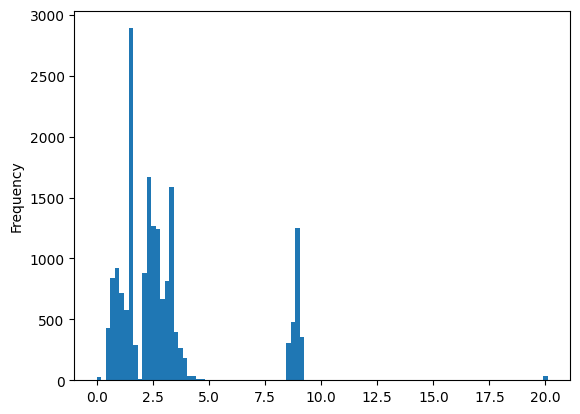

In [12]:
df.Total_UNCY = df.Total_UNCY.astype(float)
df.Total_UNCY.plot.hist(bins=100)

In [13]:
df.groupby("filename").Total_UNCY.mean().sort_values(ascending=False).head(50)

filename
Retrolens/Marlborough/CloudyBay/Shorelines/CloudyBay_02FEB2016.shp                   20.106837
Retrolens/Marlborough/WairauRiver/Shorelines/WairauRiver_07JAN2016.shp               20.051572
Retrolens/Marlborough/CliffordBay/Shorelines/CliffordBay_07JAN2016.shp               20.023509
Retrolens/Nelson/BoulderBank/Shorelines/BoulderBank_06FEB1967.shp                     9.665489
Retrolens/Tasman/MoutereSpit/Shorelines/MoutereSpit_04FEB1967.shp                     9.644290
Retrolens/Manawatu/HokioBeach/Shorelines/HokioBeach_30NOV1978.shp                     9.224321
Retrolens/Southland/MasonsBay/Shorelines/MasonsBay_10DEC1958.shp                      9.207819
Retrolens/Marlborough/CloudyBay/Shorelines/CloudyBay_04DEC2000.shp                    9.183342
Retrolens/HawkesBay/BayView/Shorelines/Bayview_17DEC1996.shp                          9.177801
Retrolens/Tasman/MoutereSpit/Shorelines/MoutereSpit_31JAN1980.shp                     9.174151
Retrolens/Bay of Plenty/PapateaBay/Shorel

In [14]:
df.groupby("Source").Total_UNCY.mean().sort_values(ascending=False).head(50)

Source
RS     5.819791
CRI    4.943288
RLN    4.060624
RL     3.948388
RLS    3.475330
NEO    3.202872
JIL    2.478732
SAT    2.478669
PLE    2.462649
MAX    2.346734
Rl     2.265828
LDS    2.216053
JIN    1.649160
Max    1.574661
max    1.568343
PNE    1.535917
GE1    1.461371
VEX         NaN
WV3         NaN
Name: Total_UNCY, dtype: float64

In [15]:
df.Photoscale.value_counts()

Photoscale
25000.0    1262
16000.0    1036
50000.0     604
44500.0     494
24000.0     445
           ... 
11600.0       2
18800.0       2
18850.0       1
19600.0       1
8300.0        1
Name: count, Length: 99, dtype: int64

In [16]:
df.Georef_ER.value_counts(dropna=False)

Georef_ER
1.17        5262
0           4070
2.09        2703
2.43        2553
2.9         2444
2.596504    1552
None         714
Name: count, dtype: int64

In [17]:
df[(df.Source == "LDS") & ~df.Total_UNCY.isna()]

,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,CPS,Proxy,Photoscale,Georef_ER,Pixel_Er,Total_UNCY,filename,Dig_ER,DATE_,DSASdate,Length,Date_,proxy,Scale_1,OBJECTID,YEAR_,SURVEY,RUN,COASTAL_SE,Shape__Len,SN,DSASDate_1,DSASDate_2,DSASDate_3,DSASDate_4,DSASDate_5,DSASDate_6,DSASDate_7,DSASDate_8,DSASDate_9,UNCY,SourceFile,Year_,Month_,Day_,DSAS_NZDAT,OBJECTID_1,geometry
51,0,Waikato,OpitoBay,2022-01-03,03/01/2022,MT,1000,None,LDS,2,1,NaN,0,0.3,0.789240,Gabrielle/Shorelines/Waikato/OpitoBay/OpitoBay_03JAN2022.shp,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,NaN,None,NaN,None,None,None,NaN,"LINESTRING (175.81790 -36.71883, 175.81800 -36.71893, 175.81810 -36.71900, 175.81820 -36.71907, 175.81824 -36.71918, 175.81833..."
52,0,Waikato,OpitoBay,2022-01-03,03/01/2022,MT,1000,None,LDS,2,1,NaN,0,0.3,0.789240,Gabrielle/Shorelines/Waikato/OpitoBay/OpitoBay_03JAN2022.shp,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,NaN,None,NaN,None,None,None,NaN,"LINESTRING (175.81732 -36.72066, 175.81722 -36.72068, 175.81711 -36.72074, 175.81691 -36.72083, 175.81672 -36.72094, 175.81650..."
53,0,Waikato,OpitoBay,2022-01-03,03/01/2022,MT,1000,None,LDS,2,1,NaN,0,0.3,0.789240,Gabrielle/Shorelines/Waikato/OpitoBay/OpitoBay_03JAN2022.shp,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,NaN,None,NaN,None,None,None,NaN,"LINESTRING (175.81362 -36.72190, 175.81353 -36.72190, 175.81338 -36.72190, 175.81323 -36.72191, 175.81309 -36.72192, 175.81292..."
54,0,Waikato,OpitoBay,2022-01-03,03/01/2022,MT,1000,None,LDS,2,1,NaN,0,0.3,0.789240,Gabrielle/Shorelines/Waikato/OpitoBay/OpitoBay_03JAN2022.shp,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,NaN,None,NaN,None,None,None,NaN,"LINESTRING (175.81121 -36.72203, 175.81114 -36.72207, 175.81102 -36.72209, 175.81088 -36.72209, 175.81072 -36.72209, 175.81052..."
55,0,Waikato,OpitoBay,2022-01-03,03/01/2022,MT,1000,None,LDS,2,1,NaN,0,0.3,0.789240,Gabrielle/Shorelines/Waikato/OpitoBay/OpitoBay_03JAN2022.shp,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,NaN,None,NaN,None,None,None,NaN,"LINESTRING (175.80607 -36.72151, 175.80588 -36.72146, 175.80572 -36.72142, 175.80553 -36.72137, 175.80539 -36.72134, 175.80526..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19288,0,Wellington,PukeruaBay,2021-02-13,13/02/2021,MD,1000,None,LDS,3,7,NaN,0,0.3,1.015332,Retrolens/Wellington/PukeruaBay/Shorelines/PukeruaBay_Wellington_13FEB2021.shp,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,NaN,None,NaN,None,None,None,NaN,"LINESTRING (174.89817 -41.02915, 174.89789 -41.02917, 174.89781 -41.02920, 174.89705 -41.02928, 174.89645 -41.02913, 174.89560..."
19289,0,Wellington,PukeruaBay,2021-02-13,13/02/2021,MD,1000,None,LDS,3,1,NaN,0,0.3,1.015332,Retrolens/Wellington/PukeruaBay/Shorelines/PukeruaBay_Wellington_13FEB2021.shp,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,NaN,None,NaN,None,None,None,NaN,"LINESTRING (174.89528 -41.02950, 174.89523 -41.02949, 174.89510 -41.02949, 174.89504 -41.02951, 174.89490 -41.02953, 174.89480..."
19290,0,Wellington,PukeruaBay,2021-02-13,13/02/2021,MD,1000,None,LDS,3,1,NaN,0,0.3,1.015332,Retrolens/Wellington/PukeruaBay/Shorelines/PukeruaBay_Wellington_13FEB2021.shp,NaN,None,None,NaN,None,NaN,NaN,NaN,None,None,None,None,NaN,None,None,None,None,None,None,None,None,None,None,NaN,None,NaN,None,None,None,NaN,"LINESTRING (174.88607 -41.02826, 174.88601 -41.02842, 174.88599 -41.02847, 174.88592 -41.02855, 174.88586 -41.02864, 174.88581..."
192

In [18]:
Sample = gpd.read_file(prefix + "/Retrolens/Tasman/MoutereRiver/Shorelines/MoutereRiver_13SEP1985.shp")
Sample

,Id,Region,Site,Date,DSASDate,Digitiser,Scale,Notes,Source,CPS,Proxy,Photoscale,Georef_ER,Pixel_Er,Total_UNCY,geometry
0,0,Tasman,MoutereRiver,1985-09-13,13/09/1985,MT,2000,Jacket Island,RL,2,1,25000,2.43,0.7342,2.641373,"LINESTRING (1603164.145 5443842.039, 1603165.468 5443825.502, 1603170.760 5443811.612, 1603182.005 5443801.028, 1603197.880 54..."
1,0,Tasman,MoutereRiver,1985-09-13,13/09/1985,MT,2000,Edge of Veg,RL,3,1,25000,2.43,0.7342,2.717508,"LINESTRING (1605037.395 5441385.040, 1605042.910 5441380.949, 1605056.404 5441366.926, 1605066.723 5441357.931, 1605074.925 54..."
2,0,None,None,1899-12-30,None,None,0,None,None,2,1,25000,2.43,0.7342,2.641373,"LINESTRING (1603036.783 5443606.602, 1603034.878 5443596.559, 1603037.259 5443589.019, 1603037.259 5443580.287, 1603040.037 54..."
3,0,Tasman,MoutereRiver,1985-09-13,13/09/1985,MT,2000,Jacket Island,RL,3,1,25000,2.43,0.7342,2.717508,"LINESTRING (1602221.433 5445643.789, 1602212.173 5445664.955, 1602205.955 5445685.593, 1602198.679 5445714.036, 1602193.387 54..."
4,0,Tasman,MoutereRiver,1985-09-13,13/09/1985,MT,2000,Edge of Veg,RL,4,1,25000,2.43,0.7342,3.275492,"LINESTRING (1603036.783 5443606.602, 1603042.339 5443620.361, 1603056.626 5443627.769, 1603074.883 5443628.034, 1603097.108 54..."


In [19]:
Sample[Sample.Source.isna()].explore()